In [1]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import linregress, ttest_ind
from scipy import stats
from wordcloud import WordCloud
import requests
import re
from bs4 import BeautifulSoup
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# Datasets


### Reading the data


In [2]:
data_tmdb = pd.read_csv("./data/tmdb_5000_movies.csv")
data_rt = pd.read_csv("./data/rotten_tomatoes_top_movies.csv")


In [3]:
data_tmdb.columns


Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

### Merging data


We want to create the runtime column for the data_rt dataset to check if there is a way to merge based on a common runtime


In [4]:
# converting object column into numerical column for runtime
data_rt['hours'] = data_rt['runtime'].str.extract(
    '(\d+)h', expand=False).fillna(0).astype(float)
data_rt['minutes'] = data_rt['runtime'].str.extract(
    '(\d+)m', expand=False).fillna(0).astype(float)
data_rt['runtime'] = data_rt['hours'] * 60 + data_rt['minutes']
data_rt = data_rt.drop(['hours', 'minutes'], axis=1)


Turns out, merging on runtime is not ideal, considering it filters out a lot of data. We will merge only on movie title instead


In [5]:
# removing duplicates in both datasets
data_tmdb = data_tmdb.drop_duplicates(subset='title')
data_rt = data_rt.drop_duplicates(subset='title')

# merging the data
movies = pd.merge(data_tmdb, data_rt, on=['title'], how='inner')


### More Accurate Movie Revenue

The TMDB dataset has Nan values for revenue, so we use TMDB API to extract box office revenues for those movies and replace Nan values with them.


In [6]:
dataset_path = './data/movies.csv'

# Load data
df = pd.read_csv(dataset_path)


In [7]:
# TMDb API key
api_key = '2764382d496b28895007a2252ea60177'


In [8]:
# Function to fetch movie revenue from TMDb
def fetch_movie_revenue(title, year):
    """this generates a new revenue column for the movies dataset. It uses the TMDb API to fetch the revenue for each movie.

    Args:
        title (object): the title of the movie
        year (int64): the year the movie was released

    Returns:
        float: the revenue of the movie according to TMDb

    Note: This particular code was optimized (not written) by ChatGPT-3.
    """
    search_url = f'https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={title}&year={year}'
    search_response = requests.get(search_url)
    search_data = search_response.json()

    if search_data['results']:
        movie_id = search_data['results'][0]['id']
        movie_url = f'https://api.themoviedb.org/3/movie/{movie_id}?api_key={api_key}'
        movie_response = requests.get(movie_url)
        movie_data = movie_response.json()

        if 'revenue' in movie_data:
            return movie_data['revenue']

    return None


Converting box office revenue into floats


In [9]:
def revenue_to_float(revenue_str):
    """this converts the revenue column from string to float

    Args:
        revenue_str (object): the revenue column as a string

    Returns:
        float64: the revenue column but as a float

    Note: This particular code was optimized (not written) by ChatGPT-3.
    """
    if not isinstance(revenue_str, str):
        return None

    # Extract the numerical value and the suffix (K or M)
    match = re.match(r'\$([\d.,]+)([KkMm]?)', revenue_str)
    if not match:
        return revenue_str

    value, suffix = match.groups()
    value = float(value.replace(',', ''))

    if suffix.lower() == 'k':
        value *= 1e3  # Convert to thousands
    elif suffix.lower() == 'm':
        value *= 1e6  # Convert to millions

    return value


Raplacing Nan values


In [10]:
# renaming box office column
movies = movies.rename(columns={'box_office_(gross_usa)': 'box_office'})

# remove nan values from box_office
movies['box_office'] = movies['box_office'].dropna()

# convert box_office to float
movies['box_office'] = movies['box_office'].apply(revenue_to_float)
movies['box_office'] = movies['box_office'].astype(float)

# create a boolean mask for rows with missing box_office values
mask = movies['box_office'].isnull()

# use apply() to fetch revenue for all rows in the mask
movies.loc[mask, 'box_office'] = movies.loc[mask].apply(
    lambda row: fetch_movie_revenue(row['title'], row['year']), axis=1)


In [11]:
movies.box_office.head()


0    200800000.0
1     89300000.0
2     10000000.0
3       656500.0
4    408100000.0
Name: box_office, dtype: float64

### Extracting year from the release data


In [12]:
movies['year'] = pd.to_datetime(movies['release_date']).dt.year

movies.year.head()


0    2010
1    2013
2    2005
3    1997
4    2016
Name: year, dtype: int64

# Exploratory Data Analysis


### Descriptive Statistics


Doing some basic descriptive statistics on the data, such as viewing the mean, median, standard deviation, etc. of the data


In [13]:
# number of rows and columns
print(movies.shape)


(340, 45)


In [14]:
# columns and their corresponsing data type
movies.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 340 entries, 0 to 339
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   budget                    340 non-null    int64  
 1   genres                    340 non-null    object 
 2   homepage                  165 non-null    object 
 3   id                        340 non-null    int64  
 4   keywords                  340 non-null    object 
 5   original_language_x       340 non-null    object 
 6   original_title            340 non-null    object 
 7   overview                  340 non-null    object 
 8   popularity                340 non-null    float64
 9   production_companies      340 non-null    object 
 10  production_countries      340 non-null    object 
 11  release_date              340 non-null    object 
 12  revenue                   340 non-null    int64  
 13  runtime_x                 340 non-null    float64
 14  spoken_lan

In [15]:
# descriptive statistics
print(movies.describe())


             budget             id  popularity       revenue   runtime_x  \
count  3.400000e+02     340.000000  340.000000  3.400000e+02  340.000000   
mean   3.748653e+07   42616.805882   42.337717  1.692944e+08  114.614706   
std    5.415082e+07   75305.127396   48.699693  2.629942e+08   24.105993   
min    0.000000e+00      11.000000    0.335195  0.000000e+00   63.000000   
25%    2.040236e+06     883.250000   14.263084  1.025791e+07   98.000000   
50%    1.500000e+07   10389.500000   29.928423  5.961214e+07  110.000000   
75%    4.400000e+07   43439.250000   56.553015  1.871199e+08  126.000000   
max    2.600000e+08  354110.000000  481.098624  1.845034e+09  219.000000   

       vote_average    vote_count   Unnamed: 0         year  critic_score  \
count    340.000000    340.000000   340.000000   340.000000    340.000000   
mean       7.070588   1676.264706   762.420588  1995.502941     87.394118   
std        0.757160   2080.800820   543.688888    20.862310     18.371228   
min    

Some columns, we've decided, don't really add much value to our analysis, so we drop them


In [16]:
# removing unnecessary columns
movies = movies.drop(['homepage', 'Unnamed: 0', 'consensus', 'link', 'status', 'release_date_(theaters)',
                      # 'original_language_x',
                      'spoken_languages', 'rating', 'tagline', 'original_language_y', 'producer',
                      'writer', 'director', 'release_date_(streaming)', 'production_co', 'sound_mix',
                      'aspect_ratio', 'view_the_collection', 'popularity', 'production_companies',
                      'production_countries'], axis=1)


In [17]:
# handling missing data
print(movies.isnull().sum())


budget                 0
genres                 0
id                     0
keywords               0
original_language_x    0
original_title         0
overview               0
release_date           0
revenue                0
runtime_x              0
title                  0
vote_average           0
vote_count             0
year                   0
synopsis               0
critic_score           0
people_score           0
total_reviews          0
total_ratings          0
type                   0
genre                  0
box_office             0
runtime_y              0
crew                   0
dtype: int64


In [18]:
# removing leading/trailing whitespace from column names
movies.columns = movies.columns.str.strip()

# checking for abnormalities
abnormal_critic_scores = movies[(
    movies['critic_score'] > 100) | (movies['critic_score'] < 0)]
if not abnormal_critic_scores.empty:
    print("Abnormal values found in critic_score column:\n", abnormal_critic_scores)

abnormal_people_scores = movies[(
    movies['people_score'] > 100) | (movies['people_score'] < 0)]
if not abnormal_people_scores.empty:
    print("Abnormal values found in people_score column:\n", abnormal_people_scores)


### Saving our new & cleaned dataset


In [19]:
movies.to_csv("./data/movies.csv", index=False)


### Basic visualizations of our data


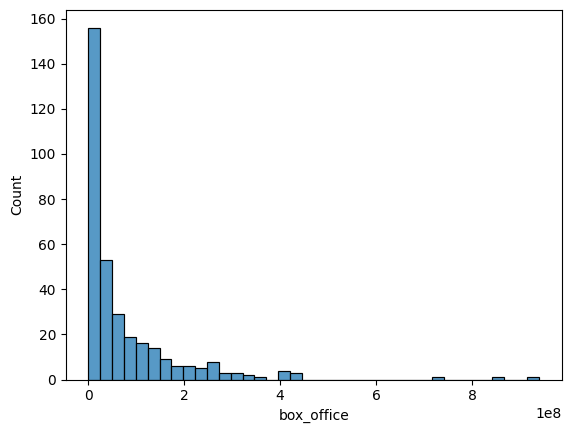

In [20]:
# histogram of box office revenue
sns.histplot(movies.box_office)
plt.show()


We want to see how the data is distributed, so we plot histograms of the data. First we needed to generate a column of log values of the box office, but only for positive values.


In [21]:
# Log transformation only on positive box_office values, set non-positive values to np.nan
movies['log_box_office'] = movies['box_office'].apply(
    lambda x: np.log(x) if x > 0 else np.nan)


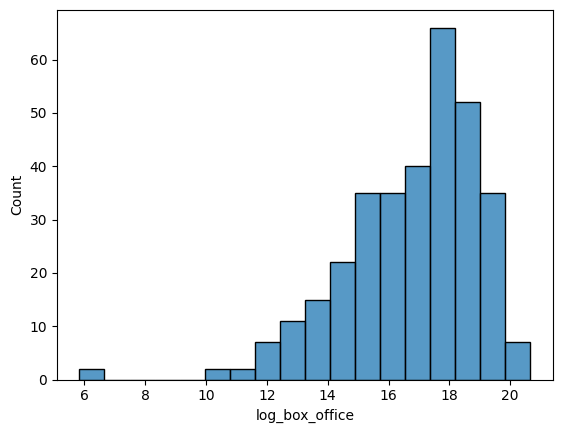

In [22]:
# histogram of log_box_office
sns.histplot(movies.log_box_office)
plt.show()


For seeing the relationship of everything in our data, we generate a pairplot of the data


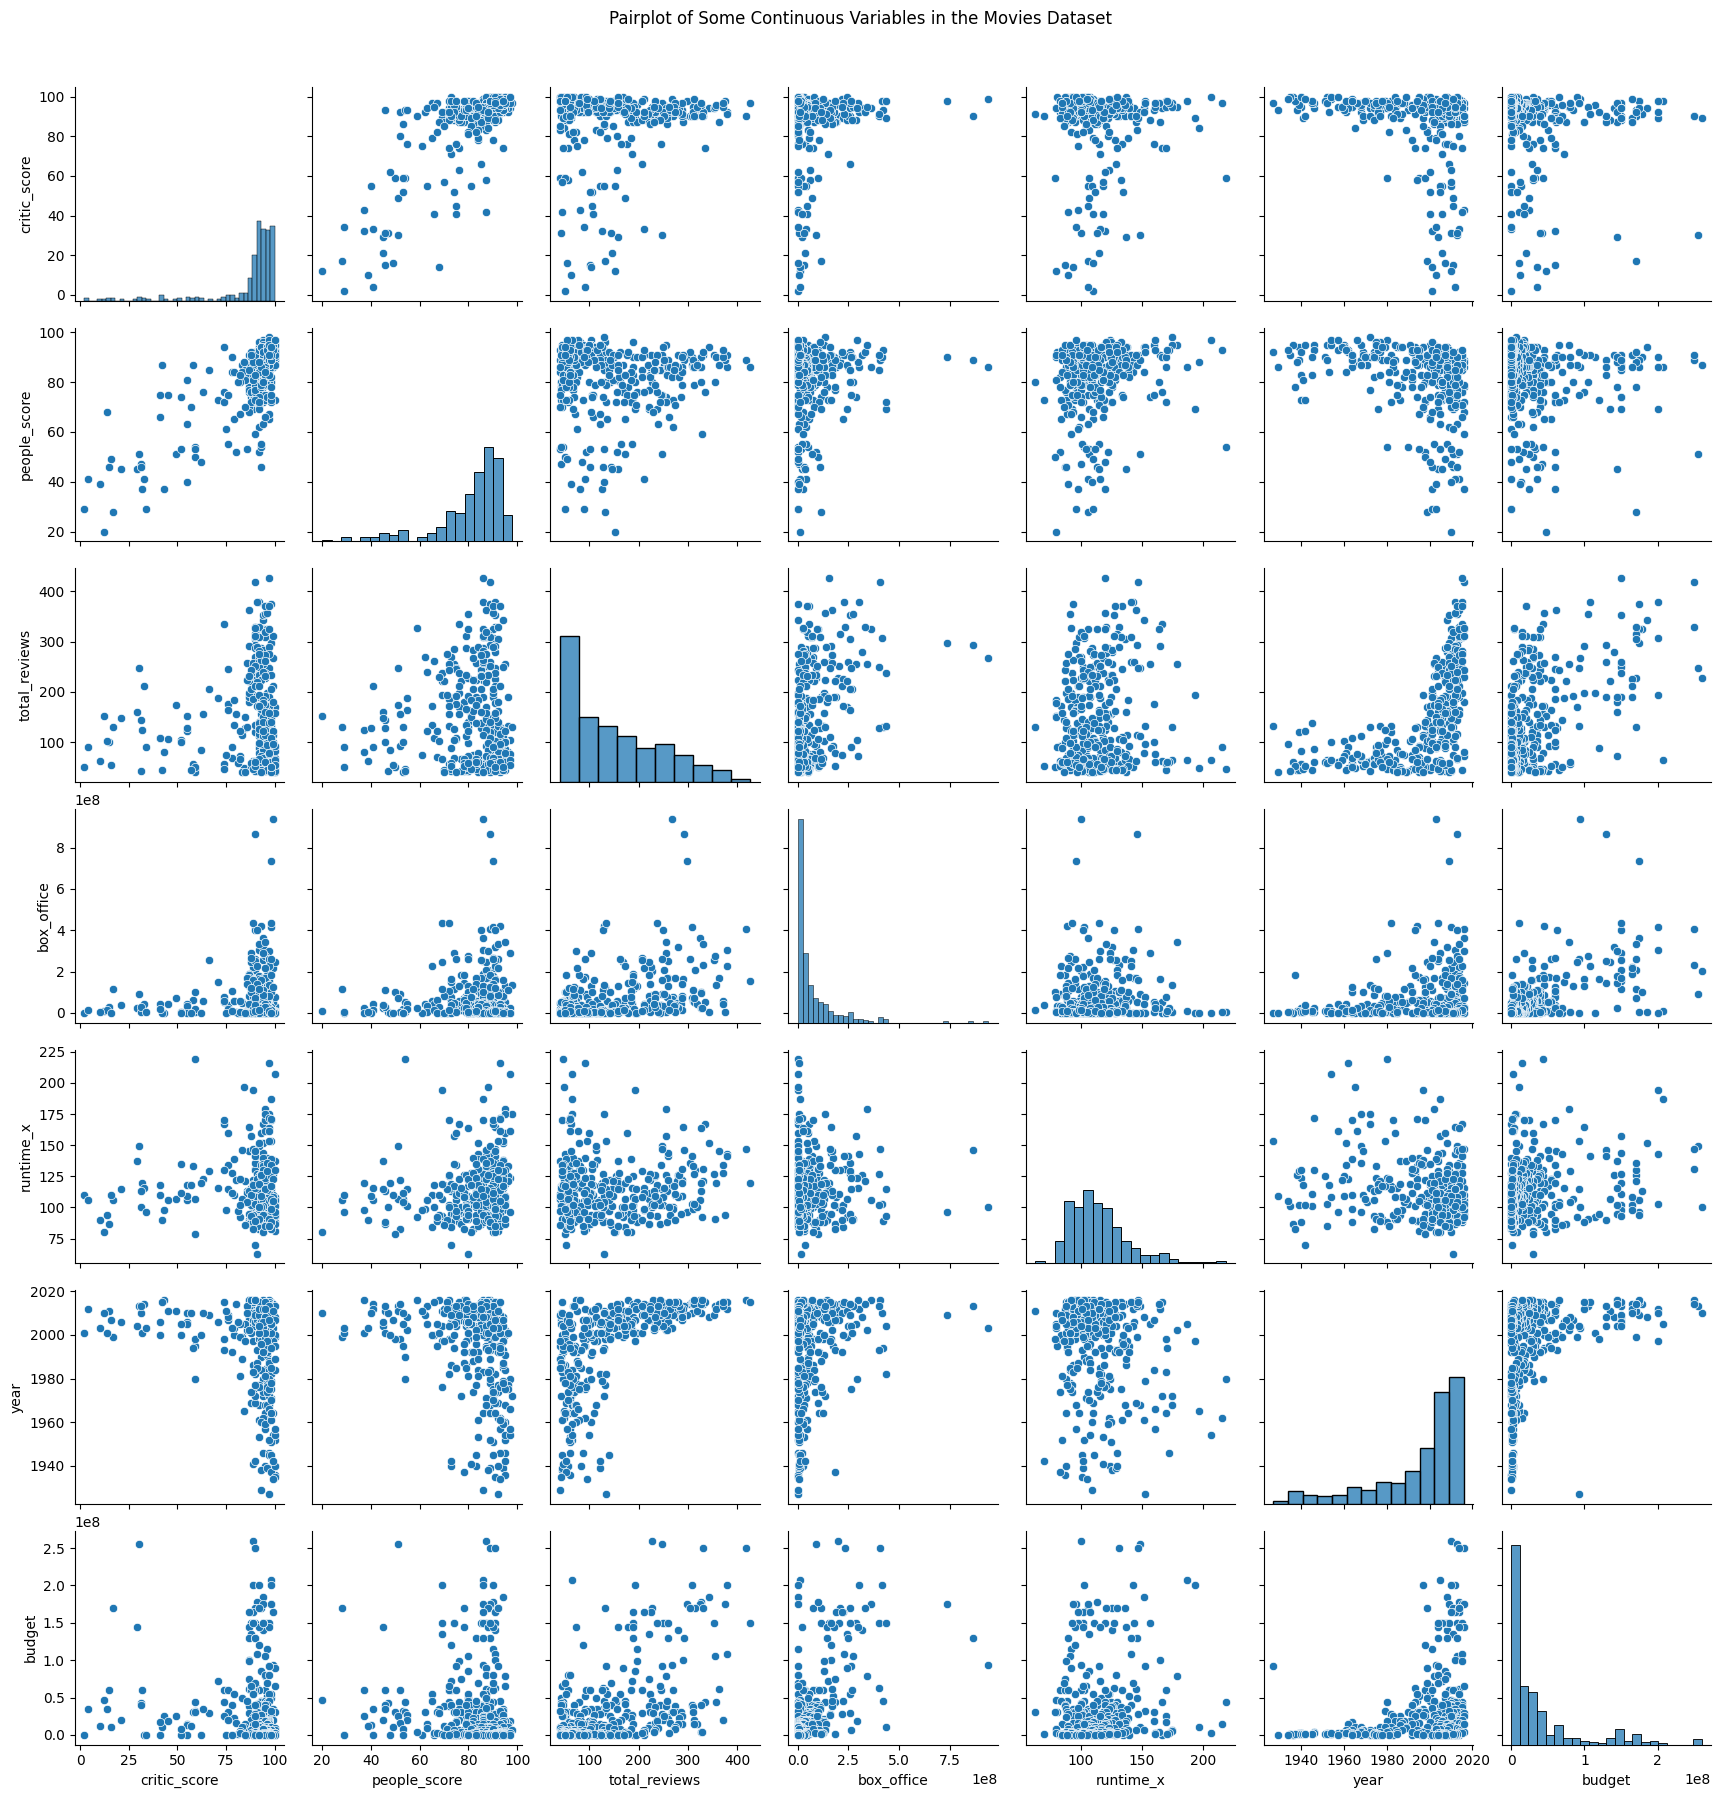

In [23]:
vars = ['critic_score', 'people_score', 'total_reviews',
        'box_office', 'runtime_x', 'year', 'budget']

# Pairplot
pp = sns.pairplot(data=movies,
                  vars=vars)

pp.fig.suptitle("Pairplot of Some Continuous Variables in the Movies Dataset",
                y=1.03)
plt.show()


We then generate a 4-plot grid of the data, to see the relationship between the variables


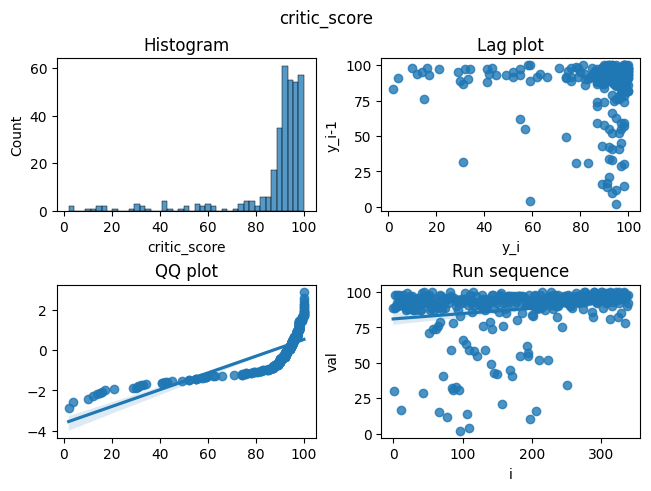

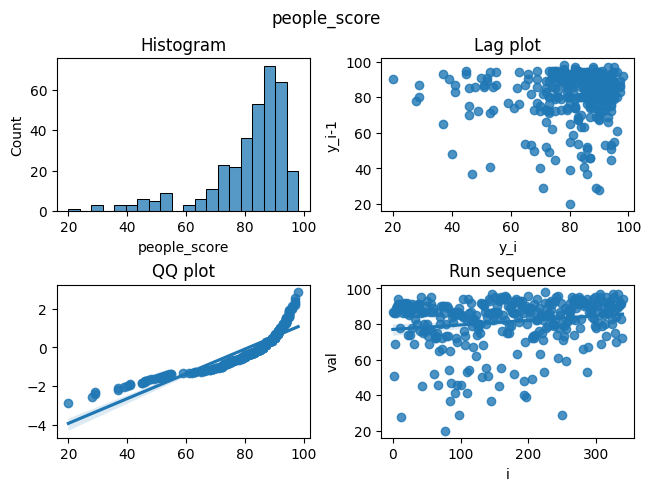

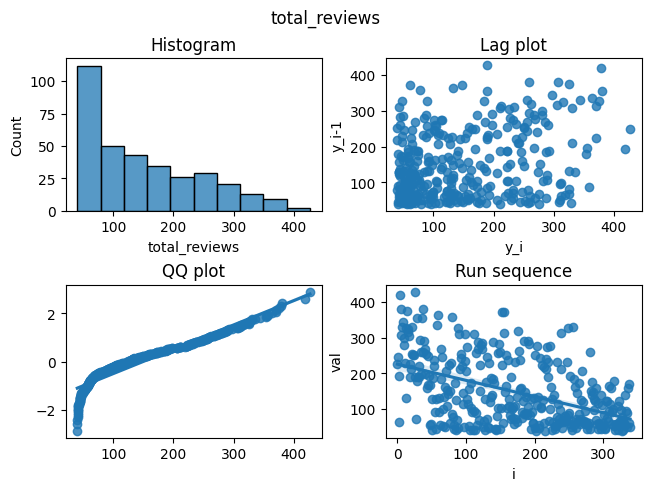

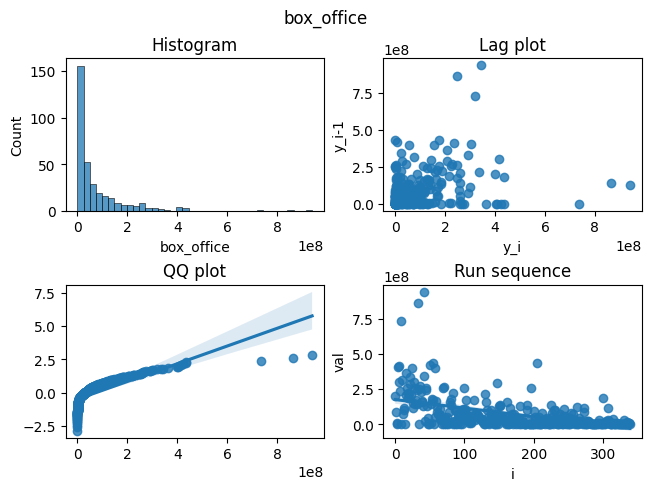

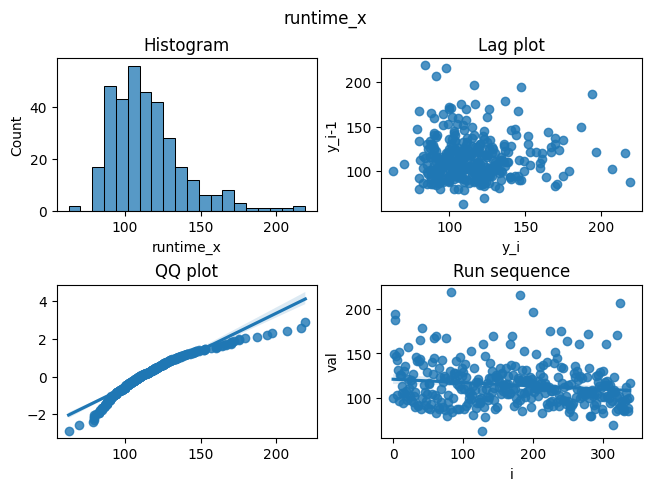

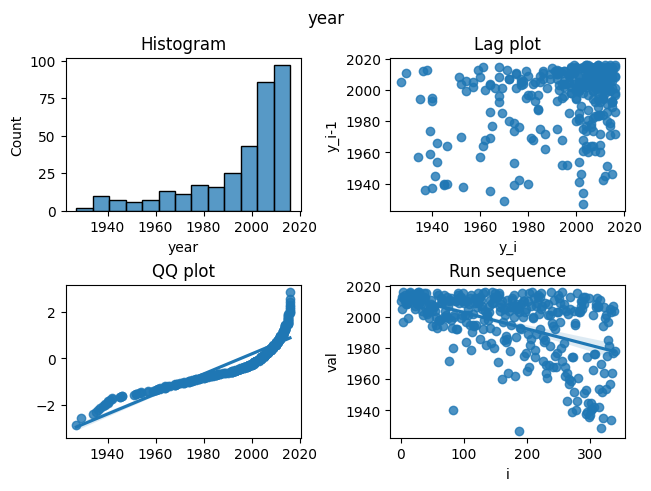

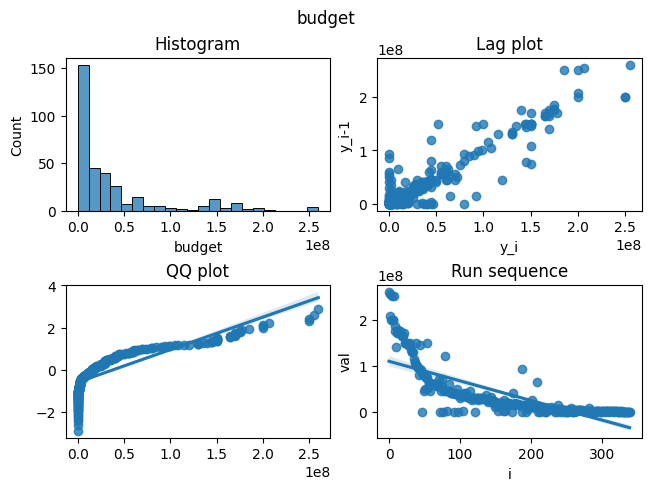

In [24]:
# 4-plot
def fourplots(df, columns):
    """
    Create 4-plots (histogram, Lag plot, QQ plot, and Run sequence) for
    selected variables in a dataframe.

    Parameters:
        df: dataframe
        columns: a subset of variables from the dataframe in a iterable format

    Returns:
        a 4-plot for each variable
    """

    for column in columns:
        fig, axs = plt.subplots(2, 2, constrained_layout=True)

        # Histogram
        ax1 = sns.histplot(df[column], ax=axs[0, 0])
        ax1.title.set_text('Histogram')

        # Lag plot
        lag = df[column].copy()
        lag = np.array(lag[:-1])
        current = df[column][1:]
        ax2 = sns.regplot(x=current, y=lag, fit_reg=False, ax=axs[0, 1])
        ax2.set_ylabel("y_i-1")
        ax2.set_xlabel("y_i")
        ax2.title.set_text('Lag plot')

        # QQ plot
        qntls, xr = stats.probplot(df[column], fit=False)
        ax3 = sns.regplot(x=xr, y=qntls, ax=axs[1, 0])
        ax3.title.set_text('QQ plot')

        # Run sequence
        ax4 = sns.regplot(x=np.arange(
            len(df[column])), y=df[column], ax=axs[1, 1])
        ax4.set_ylabel("val")
        ax4.set_xlabel("i")
        ax4.title.set_text('Run sequence')

        plt.suptitle(column)
        plt.show()


fourplots(movies, vars)


And finally we create some boxplots to see the distribution of the data


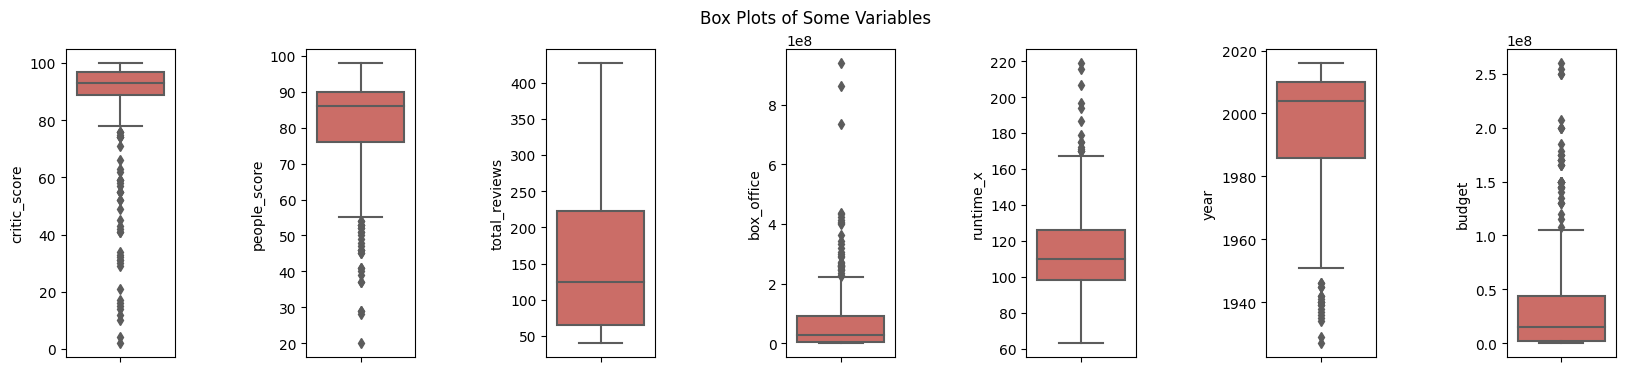

In [25]:
# box plots
def boxplots(df, columns, hue=None, palette=None):
    """
    Create box plots of selected variables in a dataframe.

    Parameters:
        df: dataframe
        columns: a subset of variables from the dataframe in a iterable format

    Returns:
        a set of boxplots
    """

    fig, axs = plt.subplots(1, len(columns), figsize=(20, 4))
    fig.subplots_adjust(wspace=1.2)

    for i in range(len(columns)):
        ax = sns.boxplot(
            y=columns[i-1],
            data=df,
            hue=hue,
            palette=palette,
            ax=axs[i-1])

    fig.suptitle("Box Plots of Some Variables")
    plt.show()


boxplots = boxplots(movies, vars, palette='hls')


# Data Analysis and Visualization


### Correlation Analysis


Now for the meat of this analysis, we will conduct a correlation analysis on the data to see which variables are most correlated with the box office revenue. We will use the Pearson correlation coefficient to measure the correlation between the variables.


In [26]:
# pairwise correlation of variables
corr = movies[vars].corr()
corr


,critic_score,people_score,total_reviews,box_office,runtime_x,year,budget
critic_score,1.000000,0.748298,0.091540,0.106137,0.031437,-0.227831,-0.051757
people_score,0.748298,1.000000,0.041527,0.116529,0.184996,-0.288333,-0.028555
total_reviews,0.091540,0.041527,1.000000,0.409820,0.060055,0.578329,0.500562
box_office,0.106137,0.116529,0.409820,1.000000,0.032506,0.198189,0.554435
runtime_x,0.031437,0.184996,0.060055,0.032506,1.000000,-0.147128,0.147943
year,-0.227831,-0.288333,0.578329,0.198189,-0.147128,1.000000,0.357211
budget,-0.051757,-0.028555,0.500562,0.554435,0.147943,0.357211,1.000000


In [27]:
# find top correlations
top_corr = corr.unstack().to_frame()
top_corr['abs'] = top_corr[0].abs()
top_corr = top_corr.sort_values(by='abs', ascending=False)
top_corr = top_corr.loc[top_corr['abs'] < 1].head(20)
top_corr = top_corr.drop_duplicates(subset=['abs'], keep='first').reset_index()
top_corr = top_corr.rename(
    columns={
        'level_0': 'Var1',
        'level_1': 'Var2',
        0: 'Correlation'
    }
)
top_corr = top_corr.iloc[:, :3]
top_corr


,Var1,Var2,Correlation
0,people_score,critic_score,0.748298
1,total_reviews,year,0.578329
2,budget,box_office,0.554435
3,total_reviews,budget,0.500562
4,box_office,total_reviews,0.409820
5,year,budget,0.357211
6,year,people_score,-0.288333
7,critic_score,year,-0.227831
8,box_office,year,0.198189
9,people_score,runtime_x,0.184996


We then generate a heatmap of our data to visually see the correlation between the variables


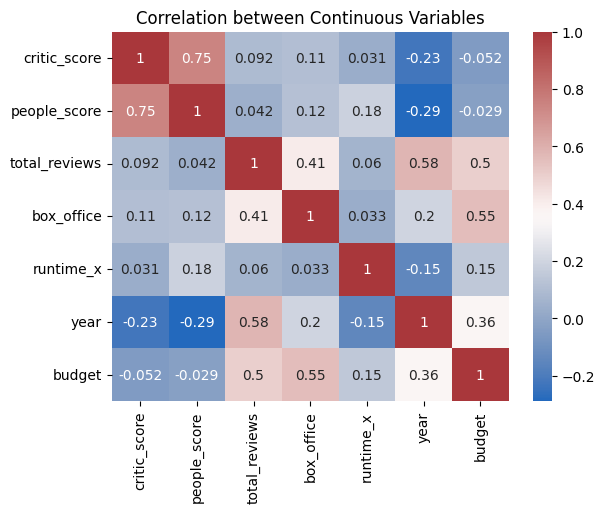

In [28]:
# heatmap
heatmap1 = sns.heatmap(corr, annot=True, cmap="vlag")
heatmap1.set_title("Correlation between Continuous Variables")
plt.show()


### OLS Regression Analysis: Which variable is a good predictor for Box Office Revenue?


Critic score and revenue


We chose an ordinary lease squared regression analysis to see which variables are good predictors for box office revenue. We will use the critic score and the budget as our independent variables, and the box office revenue as our dependent variable.


In [29]:
# perform ordinary least squares regression analysis between critic score and revenue
model = smf.ols('box_office ~ critic_score', data=movies).fit()
summary = model.summary()
print(summary)


                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.851
Date:                Sun, 30 Apr 2023   Prob (F-statistic):             0.0505
Time:                        20:54:16   Log-Likelihood:                -6799.0
No. Observations:                 340   AIC:                         1.360e+04
Df Residuals:                     338   BIC:                         1.361e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      1.44e+07    3.1e+07      0.464   

In [30]:
# store information into a dataframe
# Chat GPT-3 helped me with this part
results = {}
results['R-squared'] = model.rsquared
results['Prob (F-statistic)'] = model.f_pvalue
results['Coefficients'] = model.params.to_dict()
results['Standard errors'] = model.bse.to_dict()
results['t-values'] = model.tvalues.to_dict()
results['p-values'] = model.pvalues.to_dict()

results = pd.DataFrame(results)


In [31]:
# checking how much the variance describes the data
print(
    f"The variability in the response variable explained by the predictor variable is {round(results['R-squared'][0] * 100, 2)}%.\n")


The variability in the response variable explained by the predictor variable is 1.13%.



We then check if the p-value is less than 0.05, which means that the variable is a good predictor for box office revenue


In [34]:
# checking the p-value for hypothesis testing on intercept and coefficient of critic_score
# this was optimized (not written) by Chat GPT-3
alpha = 0.05
if results['Prob (F-statistic)'][0] > alpha:
    print(
        f"The p-value for the F-statistic is greater than {alpha}, and we fail to reject the null hypothesis.")
    print(f"Null hypothesis: There is no statistically significant relationship between critic_score and revenue.\n")
else:
    print(
        f"The p-value for the F-statistic is less than or equal to {alpha}, and we can reject the null hypothesis.")
    print(f"Alternative hypothesis: There is a statistically significant relationship between critic_score and revenue.\n")


The p-value for the F-statistic is greater than 0.05, and we fail to reject the null hypothesis.
Null hypothesis: There is no statistically significant relationship between critic_score and revenue.



Budget and revenue


In [35]:
# linear regression between budget and revenue
model_budget = smf.ols('box_office ~ budget', data=movies).fit()
summary_budget = model_budget.summary()
print(summary_budget)


                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     150.0
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           8.56e-29
Time:                        20:54:46   Log-Likelihood:                -6738.5
No. Observations:                 340   AIC:                         1.348e+04
Df Residuals:                     338   BIC:                         1.349e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.867e+07   6.48e+06      4.422      0.0

In [36]:
# store information into a dataframe
# Note: This particular code was helped (not written) by ChatGPT-3.
results_budget = {}
results_budget['R-squared'] = model_budget.rsquared
results_budget['Prob (F-statistic)'] = model_budget.f_pvalue
results_budget['Coefficients'] = model_budget.params.to_dict()
results_budget['Standard errors'] = model_budget.bse.to_dict()
results_budget['t-values'] = model_budget.tvalues.to_dict()
results_budget['p-values'] = model_budget.pvalues.to_dict()

results_budget = pd.DataFrame(results_budget)


In [37]:
# checking how much the variance describes the data
print(
    f"The variability in the response variable explained by the predictor variable is {round(results_budget['R-squared'][0] * 100, 2)}%.\n")


The variability in the response variable explained by the predictor variable is 30.74%.



In [38]:
# checking the p-value for hypothesis testing on intercept and coefficient of budget
alpha = 0.05
if results_budget['Prob (F-statistic)'][0] > alpha:
    print(
        f"The p-value for the F-statistic is greater than {alpha}, and we fail to reject the null hypothesis.")
    print(f"Null hypothesis: There is no statistically significant relationship between critic_score and revenue.\n")
else:
    print(
        f"The p-value for the F-statistic is less than or equal to {alpha}, and we can reject the null hypothesis.")
    print(f"Alternative hypothesis: There is a statistically significant relationship between critic_score and revenue.\n")


The p-value for the F-statistic is less than or equal to 0.05, and we can reject the null hypothesis.
Alternative hypothesis: There is a statistically significant relationship between critic_score and revenue.



Number of reviews and revenue


In [39]:
# linear regression between the number of reviews and revenue
model_review = smf.ols('box_office ~ total_reviews', data=movies).fit()
summary_review = model_review.summary()
print(summary_review)


                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     68.23
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           3.34e-15
Time:                        20:54:52   Log-Likelihood:                -6769.7
No. Observations:                 340   AIC:                         1.354e+04
Df Residuals:                     338   BIC:                         1.355e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -2.866e+06    1.1e+07     -0.261

Multiple regression


In [40]:
# multiple regression between revenue as the dependent variable and
# budget and number of reviews as the independent variables
model_review_budget = smf.ols(
    'box_office ~ budget * total_reviews', data=movies).fit()
summary_review_budget = model_review_budget.summary()
print(summary_review_budget)


                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     57.29
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           6.22e-30
Time:                        20:54:53   Log-Likelihood:                -6730.7
No. Observations:                 340   AIC:                         1.347e+04
Df Residuals:                     336   BIC:                         1.348e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.572e+07 

In [41]:
# multiple regression between revenue as the dependent variable and
# budget, number of reviews, and audience score as the independent variables
model_complex = smf.ols(
    'box_office ~ budget * total_reviews * people_score', data=movies).fit()
summary_complex = model_complex.summary()
print(summary_complex)


                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     26.68
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           5.85e-29
Time:                        20:54:55   Log-Likelihood:                -6725.1
No. Observations:                 340   AIC:                         1.347e+04
Df Residuals:                     332   BIC:                         1.350e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

We then create regression plots between the box office revenue and the other variables to see the relationship between them


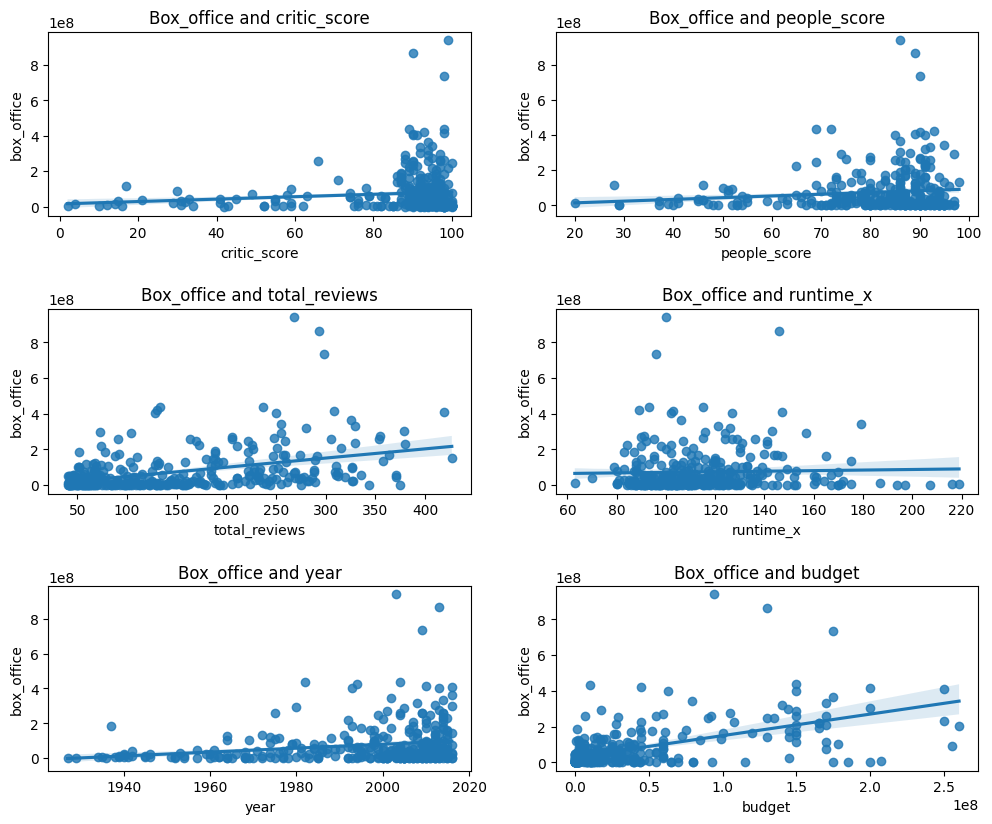

In [42]:
# visulization for box_office and other variables
plt.figure(figsize=(12, 24))
i = 0

for var in vars:
    if var == 'box_office':
        pass
    else:
        plt.subplot(7, 2, i + 1).set_title(f"Box_office and {var}")
        sns.regplot(x=var, y='box_office', data=movies)
        i += 1
        plt.subplots_adjust(hspace=0.5)

# plt.suptitle("Box Office and Other Variables")
plt.show()


### ANOVA test


Is there a difference in box office revenue across different genres? We will use an ANOVA test to tell.


In [43]:
# movie genres
movies.type.value_counts()


Action & Adventure           44
Animation                    43
Western                      40
Horror                       28
Classics                     25
Sports & Fitness             24
Romance                      20
Comedy                       18
Musical & Performing Arts    14
Drama                        14
Kids & Family                14
Documentary                  13
Television                   12
Special Interest             10
Mystery & Suspense            8
Art House & International     8
Science Fiction & Fantasy     5
Name: type, dtype: int64

A boxplot is a good way to visualize the difference in box office revenue across different genres


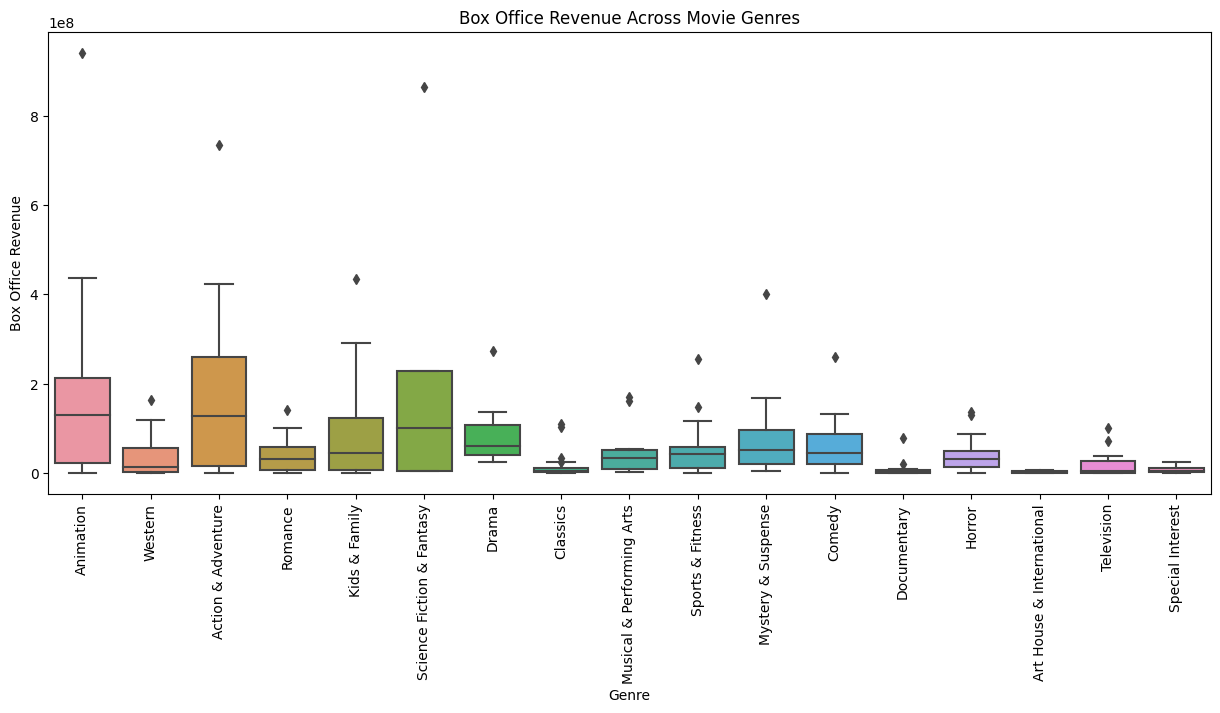

In [44]:
# boxplot of box_office across movie genres
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(ax=ax, x="type", y="box_office", data=movies)
plt.xticks(rotation=90)
ax.set_title("Box Office Revenue Across Movie Genres")
ax.set_xlabel("Genre")
ax.set_ylabel("Box Office Revenue")

plt.show()


Now we will actually conduct our ANOVA test to see if there is a significant difference in box office revenue across different genres


In [45]:
# np.random.seed(42)

# specify the linear model formula
formula = 'box_office ~ type'
# formula = 'critic_score ~ C(genre)'

# fit the linear model using the specified formula
model = smf.ols(formula, movies).fit()


In [46]:
# calculate ANOVA table statistics
anova_table = sm.stats.anova_lm(model, type=2)

# display the ANOVA table
print(f"{anova_table}\n")
print(f"{model.summary()}\n")

# perform hypothesis test using p-value from ANOVA table - optimized by Chat GPT-3
alpha = 0.05
p_value = anova_table['PR(>F)'][0]

if p_value > alpha:
    print(f"The p-value of {p_value} is bigger than {alpha}, so we fail to reject the null hypothesis,\
 and there is no statistically significant difference in revenue across different genres.\n")
else:
    print(f"The p-value of {p_value} is smaller than {alpha}, so we reject the null hypothesis,\
 and there is statistically significant difference in revenue across different genres.")


             df        sum_sq       mean_sq         F        PR(>F)
type       16.0  1.130039e+18  7.062744e+16  6.368788  2.080638e-12
Residual  323.0  3.581948e+18  1.108962e+16       NaN           NaN

                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     6.369
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           2.08e-12
Time:                        20:55:07   Log-Likelihood:                -6754.3
No. Observations:                 340   AIC:                         1.354e+04
Df Residuals:                     323   BIC:                         1.361e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
     

Which genres have the difference? We will use Tukey's HSD test to find out


In [47]:
# Tukey's HSD test
tukey = pairwise_tukeyhsd(movies['box_office'], movies['type'])
tukey.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
Action & Adventure,Animation,-7615135.092,1.0,-86346527.0503,71116256.8664,False
Action & Adventure,Art House & International,-156276451.4205,0.0143,-297393410.5859,-15159492.255,True
Action & Adventure,Classics,-143676759.3655,0.0,-235632124.3011,-51721394.4298,True
Action & Adventure,Comedy,-93507251.9343,0.1232,-196233664.8768,9219161.0081,False
Action & Adventure,Documentary,-148835141.4301,0.0013,-264736434.9453,-32933847.9148,True
Action & Adventure,Drama,-74840721.1883,0.6426,-187501438.0136,37819995.637,False
Action & Adventure,Horror,-120567152.2955,0.0004,-209325613.3939,-31808691.197,True
Action & Adventure,Kids & Family,-57488060.2597,0.9363,-170148777.085,55172656.5655,False
Action & Adventure,Musical & Performing Arts,-112865081.974,0.049,-225525798.7993,-204365.1488,True
Action & Adventure,Mystery & Suspense,-60346857.0455,0.9875,-201463816.2109,80770102.12,False


### T-test: Language and Movie Scores


Language might also be an important factor we should consider. We will use a t-test to see if there is a significant difference in movie scores across different languages


In [48]:
movies.original_language_x.value_counts()


en    313
fr      6
ja      4
it      4
ru      2
es      2
de      2
hi      2
ko      1
zh      1
ar      1
id      1
fa      1
Name: original_language_x, dtype: int64

In [49]:
# create a language column and group languages into English and non-English
movies['language'] = movies['original_language_x'].apply(
    lambda x: 'English' if x == 'en' else 'non-English')

# divide into sub datasets of English and non-English movies
eng_movies = movies[movies.language == "English"]
non_eng_movies = movies[movies.language == "non-English"]

print(f"We have {len(eng_movies)} movies in English and {len(non_eng_movies)} movies in other languages.")


We have 313 movies in English and 27 movies in other languages.


Using boxplots, we can visualize the difference in movie scores and box office across different languages


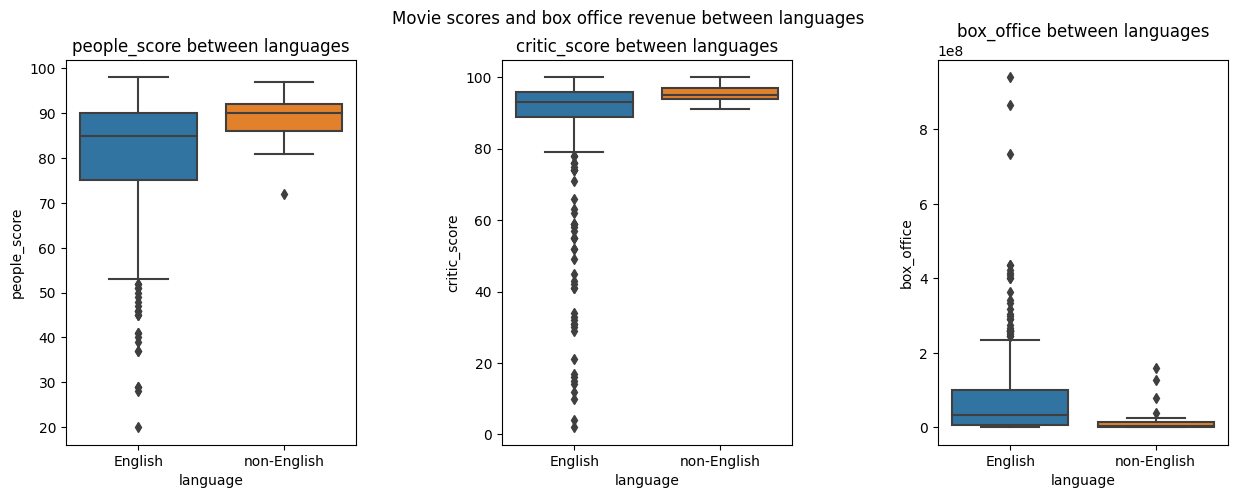

In [50]:
vars = ['people_score', 'critic_score', 'box_office']

# creat boxplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.subplots_adjust(wspace=0.5)

for i in range(len(vars)):
    ax = sns.boxplot(
        x='language',
        y=vars[i-1],
        data=movies,
        ax=axs[i-1]
    )
    ax.set_title(f"{vars[i-1]} between languages")

plt.suptitle("Movie scores and box office revenue between languages")
plt.show()

# fig, axs = plt.subplots(1, 3)
# fig.subplots_adjust(wspace=0.5)

# for i in range(len(vars)):
#     ax = sns.histplot(
#         x=vars[i-1],
#         data=movies,
#         ax=axs[i-1]
#     )
# plt.show()


In [51]:
tvars = ['people_score', 'critic_score', 'box_office']

for v in tvars:
    print(ttest_ind(eng_movies[v], non_eng_movies[v]))


Ttest_indResult(statistic=-2.922231491298301, pvalue=0.0037093068591146578)
Ttest_indResult(statistic=-2.4790953990028775, pvalue=0.013658800006118115)
Ttest_indResult(statistic=2.504329502663411, pvalue=0.012738862694256368)


### JointGrid Plot for Critic Scores vs. Revenue


A JointGrid Plot is a great way to visualize the relationship between two variables, and also see the distribution of each variable


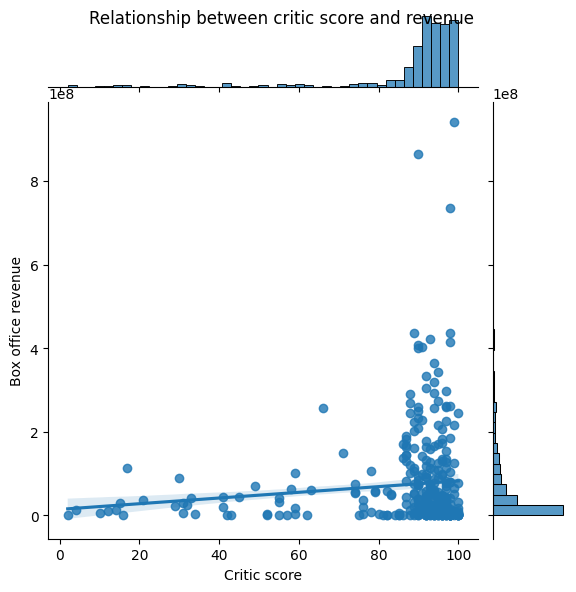

In [52]:
# create jointgrid plot
g = sns.JointGrid(data=movies, x="critic_score", y="box_office")

# add regplot
sns.regplot(x="critic_score", y="box_office", data=movies, ax=g.ax_joint)

# add histplot
sns.histplot(x="critic_score", data=movies, ax=g.ax_marg_x, kde=False)
sns.histplot(y="box_office", data=movies, ax=g.ax_marg_y, kde=False)

# set title and axis labels
g.set_axis_labels("Critic score", "Box office revenue")
g.fig.suptitle("Relationship between critic score and revenue")

# show plot
plt.show()


### Heatmap between movie genre and box office revenue


A heatmap here would be useful for visualizing the relationship between movie genre and box office revenue.

In order to create a heatmap between genre and revenue, revenue needs to be divided into bins.


In [53]:
# find revenue percentiles
quant = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

for q in quant:
    print(
        f"The {q * 100} percentile of revenue is ${movies.box_office.quantile(q)}.")


The 10.0 percentile of revenue is $619800.0.
The 20.0 percentile of revenue is $2441236.0.
The 30.0 percentile of revenue is $6270000.0.
The 40.0 percentile of revenue is $14371151.999999998.
The 50.0 percentile of revenue is $28835451.0.
The 60.0 percentile of revenue is $45660000.0.
The 70.0 percentile of revenue is $73949999.99999999.
The 80.0 percentile of revenue is $117700321.59999998.
The 90.0 percentile of revenue is $217040000.0.
The 100.0 percentile of revenue is $940335536.0.


In [54]:
# cut into 10 bins
revenue_cat = pd.cut(
    movies.box_office,
    bins=[0, 619800.0, 2441236.0, 6270000.0, 14371152, 28835451.0,
          45660000.0, 73950000, 117700322, 217040000.0, 940335536.0],
    labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%',
            '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
)


In [55]:
# create a new column with revenue categories
movies.insert(1, 'box_office_bin', revenue_cat)
movies.head()


,budget,box_office_bin,genres,id,keywords,original_language_x,original_title,overview,release_date,revenue,...,people_score,total_reviews,total_ratings,type,genre,box_office,runtime_y,crew,log_box_office,language
0,260000000,80-90%,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...",38757,"[{""id"": 1562, ""name"": ""hostage""}, {""id"": 2343,...",en,Tangled,When the kingdom's most wanted-and most charmi...,2010-11-24,591794936,...,87.0,227,"100,000+",Animation,"musical, comedy, fantasy, animation, kids and ...",200800000.0,101.0,"Mandy Moore, Zachary Levi, Donna Murphy, Ron P...",19.117820,English
1,255000000,70-80%,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",57201,"[{""id"": 1556, ""name"": ""texas""}, {""id"": 2673, ""...",en,The Lone Ranger,The Texas Rangers chase down a gang of outlaws...,2013-07-03,89289910,...,51.0,247,"25,000+",Western,"western, adventure, action",89300000.0,149.0,"Johnny Depp, Armie Hammer, William Fichtner, T...",18.307512,English
2,207000000,30-40%,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 18, ""...",254,"[{""id"": 774, ""name"": ""film business""}, {""id"": ...",en,King Kong,"In 1933 New York, an overly ambitious movie pr...",2005-12-14,550000000,...,86.0,65,"50,000+",Action & Adventure,"adventure, fantasy",10000000.0,100.0,"Fay Wray, Bruce Cabot, Robert Armstrong, Frank...",16.118096,English
3,200000000,10-20%,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",597,"[{""id"": 2580, ""name"": ""shipwreck""}, {""id"": 298...",en,Titanic,"84 years later, a 101-year-old woman named Ros...",1997-11-18,1845034188,...,69.0,193,"250,000+",Romance,"drama, history, romance",656500.0,195.0,"Leonardo DiCaprio, Kate Winslet, Billy Zane, K...",13.394678,English
4,250000000,90-100%,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",271110,"[{""id"": 393, ""name"": ""civil war""}, {""id"": 6091...",en,Captain America: Civil War,"Following the events of Age of Ultron, the col...",2016-04-27,1153304495,...,89.0,419,"100,000+",Action & Adventure,"adventure, fantasy, action",408100000.0,146.0,"Chris Evans, Robert Downey Jr., Scarlett Johan...",19.827023,English


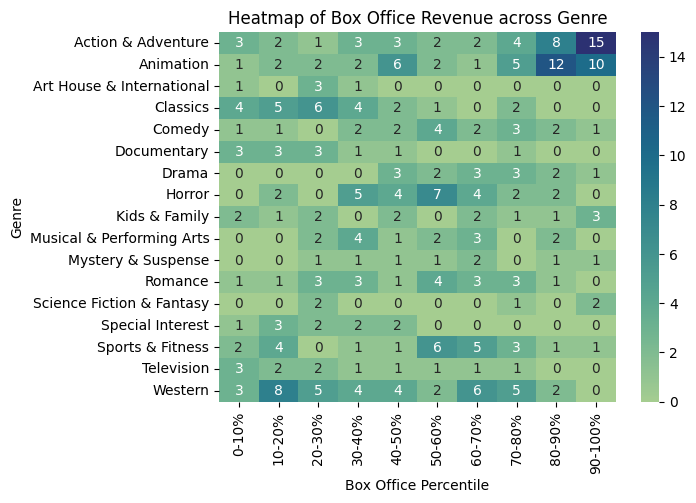

In [56]:
heatmap2 = sns.heatmap(pd.crosstab(
    movies.type, movies.box_office_bin), cmap='crest', annot=True)
heatmap2.set_xlabel("Box Office Percentile")
heatmap2.set_ylabel("Genre")
heatmap2.set_title("Heatmap of Box Office Revenue across Genre")
plt.show()


# Create a wordcloud from movie synopses


While wordclouds are not the most useful tool for data analysis, they are a great way to visualize the most common words in a dataset. We will use the movie synopses to create a wordcloud.


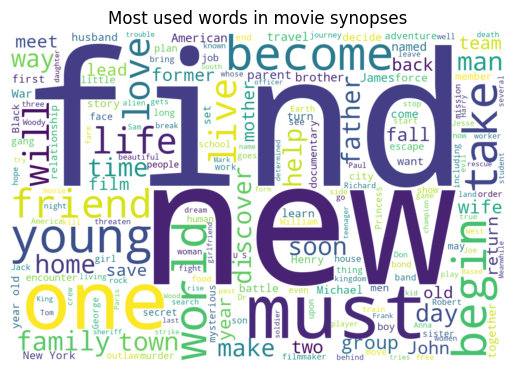

In [57]:
# movies.columns
# movies.synopsis

synopsis = ' '.join(movies['synopsis'].tolist())

wordcloud = WordCloud(width=1200, height=800,
                      background_color='white').generate(synopsis)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most used words in movie synopses')
plt.show()


### End of notebook
